In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

---
### Data

In [2]:
N = int(1e6)    # number of samples
D = 20          # number of features
RF = 4          # number of redundant features

X, y = make_classification(
    n_samples=N, 
    n_features=D, 
    n_informative=D-RF, 
    n_redundant=RF, 
    n_clusters_per_class=2, 
    class_sep=1.5)

---
### Functions

In [3]:
def sample(n, rs=None):
    '''Return a randomly sampled dataset of size n from the population X, y.

    Parameter:
      n   size of training set
      rs  random state 

    Return:
        X_tr, y_tr  training set
    '''
    X_tr,_,y_tr,_ = train_test_split(X, y, train_size=n, random_state=rs)
    return X_tr, y_tr

def rademacher(clf, X, K=100):
    '''Return empirical Rademacher complexity.
    
    Parameter:
        clf  classifier
        X    training set of size n
        K    number of noise samples of size n

    Return:
        RAD  empirical Rademacher complexity
    '''
    n = X.shape[0]
    rad = np.zeros(K)
    for k in range(K):
        sigma = 2*np.random.randint(2, size=n)-1
        clf.fit(X, sigma)
        rad[k] = np.dot(sigma, clf.predict(X))/n
    RAD = rad.mean()
    return RAD

def vcbound(n, err_train, vcdim, delta):
    '''Return VC bound.

    Parameter:
        n         size of training set
        err_train training error
        vcdim     VC dimension of classifier
        delta     confidence level
    Return: 
        vc_bound  VC bound
    '''
    vc_a = vcdim*np.log((2*np.e*n/vcdim))  
    vc_b = np.log(4/delta) 
    vc_bound = err_train + np.sqrt(8/n * (vc_a + vc_b))
    return vc_bound


def eval(clf, vcdim, X_train, y_train, delta=0.1, K=100):
    '''Evaluate classifier on training set and population.
    
    Parameter:  
        clf      classifier
        vcdim    VC dimension of classifier
        X_train  training set
        y_train  training labels
        delta    confidence level
        K        number of noise samples for empirical Rademacher complexity

    Return: [err_train, err_test, rad, rad_bound, vc_bound]
        err_train  training error
        err_test   true error
        rad        empirical Rademacher complexity
        rad_bound  Rademacher bound
        vc_bound   VC bound
    '''
    n = len(y_train)
    clf.fit(X_train, y_train)
    err_train = 1.-clf.score(X_train, y_train)
    err_test = 1.-clf.score(X, y)
    rad = rademacher(clf, X_train, K)
    rad_bound = err_train + 2*rad + 3 * np.sqrt(np.log(2/delta)/(2*n))
    vc_bound = vcbound(n, err_train, vcdim, delta)
    return [err_train, err_test, rad, rad_bound, vc_bound]

def experiment(clf, vcdim, sizes, delta=0.1, K=100):
    '''Run experiment for different training set sizes. This function returns the 
        training error, 
        true error, 
        empirical Rademacher complexity, 
        Rademacher bound, 
        VC bound 
    for each training set size
    
    Parameter:
        clf      classifier
        vcdim    VC dimension of classifier
        sizes    list of training set sizes
        delta    confidence level
        K        number of noise samples for empirical Rademacher complexity
    
    Return:
        results  array of results for each training set size
    '''
    results = []
    X, y = sample(sizes[-1])
    for n in sizes:
        res = eval(clf, vcdim, X[:n], y[:n], delta=delta, K=K)
        results.append(res)
    return np.array(results)

def plot(results, sizes):
    plt.figure(figsize=(10,6))
    plt.plot(sizes, results[:,0], label='train error')
    plt.plot(sizes, results[:,1], label='true error')
    plt.plot(sizes, results[:,2], label='rademacher')
    plt.plot(sizes, results[:,3], label='rad bound')
    plt.plot(sizes, results[:,4], label='vc bound')
    plt.yscale('log')
    plt.xlabel('n')
    plt.ylabel('error')
    plt.legend()
    plt.show()

---
### Experiment

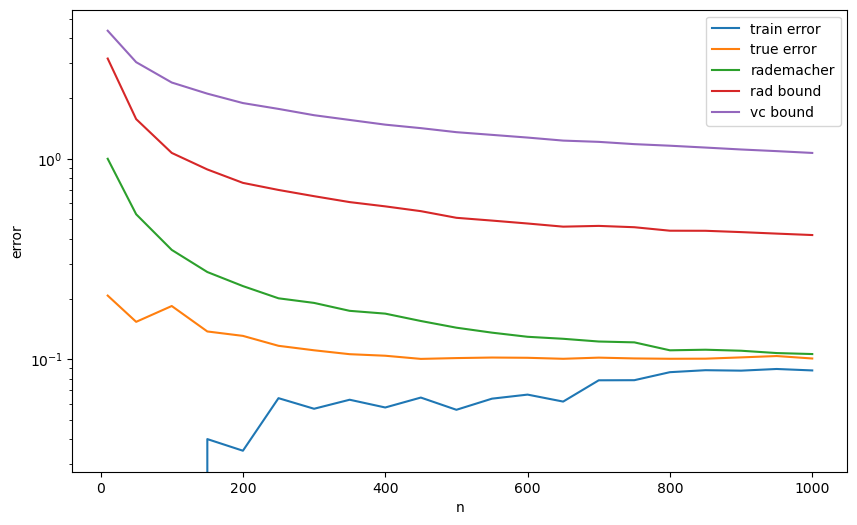

In [4]:
sizes = np.arange(0, 1001, 50)
sizes[0] = 10
lr = LogisticRegression(penalty = None, max_iter=1000)
results = experiment(lr, D+1, sizes)
plot(results, sizes)